# Importing packages and reading in data

In [39]:
import xgboost as xgb
import pandas as pd
import numpy as np
#from sdv.single_table import CTGANSynthesizer
#from sdv.metadata import SingleTableMetadata
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from imblearn.under_sampling import RandomUnderSampler

train_tgt = pd.read_csv("Data/Train_data_tgt.csv") 
train_tgt = train_tgt.drop(columns = ['Unnamed: 0'])
test_tgt = pd.read_csv("Data/Test_data_tgt.csv")
test_tgt = test_tgt.drop(columns = ['Unnamed: 0'])
train_sep = pd.read_csv("Data/Train_data_sep.csv")
train_sep = train_sep.drop(columns = ['Unnamed: 0'])
test_sep = pd.read_csv("Data/Test_data_sep.csv")
test_sep = test_sep.drop(columns = ['Unnamed: 0'])
train_OG = pd.read_csv("Data/train_OG.csv")
train_OG = train_OG.drop(columns = ['Unnamed: 0'])
test_OG = pd.read_csv("Data/test_OG.csv")
test_OG = test_OG.drop(columns = ['Unnamed: 0'])


# Class imbalance functions

In [31]:
def random_undersample(train_data):
    rus = RandomUnderSampler()
    X = train_data.drop(columns = ["label","gene_id","Transcript_ID"])
    Y = train_data['label'] 
    X_resampled, y_resampled = rus.fit_resample(X, Y)
    output = pd.concat([X_resampled,y_resampled],axis = 1) 
    return output

def GANsampling(train_data,no_of_samples = 50000):
    data = train_data.drop(columns = ["gene_id","Transcript_ID","Base_seq"])
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(data=data)
    metadata.update_column("label",sdtype="categorical")
    CTGAN = CTGANSynthesizer(
        metadata, 
        enforce_rounding=False,
        epochs=50,
        verbose=False
    )
    CTGAN.fit(data)
    CT_samples = CTGAN.sample(num_rows=no_of_samples)
    New_positive = CT_samples[CT_samples["label"] == 1]
    output = pd.concat([data,New_positive],axis = 0, ignore_index = True) 
    return output

def adasyn_sample(train):
    X = train.drop(columns = ["label","gene_id","Transcript_ID","Base_seq"])
    y = train['label']
    adasyn_model = ADASYN(sampling_strategy='auto', random_state=42)
    X_adasyn_sample, y_adasyn_sample = adasyn_model.fit_resample(X, y)
    output = pd.concat([X_adasyn_sample, y_adasyn_sample], axis=1)
    return output

# Principal Components with mean and std together

### Random Undersample

In [3]:
new_train_data = random_undersample(train_tgt)
X_train = new_train_data.drop('label', axis=1)
Y_train = new_train_data['label']
X_test = test_tgt.drop(columns = ["label","gene_id","Transcript_ID","Base_seq"],axis = 1)
Y_test = test_tgt['label']

model = xgb.XGBClassifier(
    objective='binary:logistic', 
    n_estimators=100,            
    max_depth=3,                
    learning_rate=0.1,          
    subsample=0.8,             
    colsample_bytree=0.8,       
)

model.fit(X_train, Y_train)

Y_pred = model.predict_proba(X_test)[:, 1]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:33:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


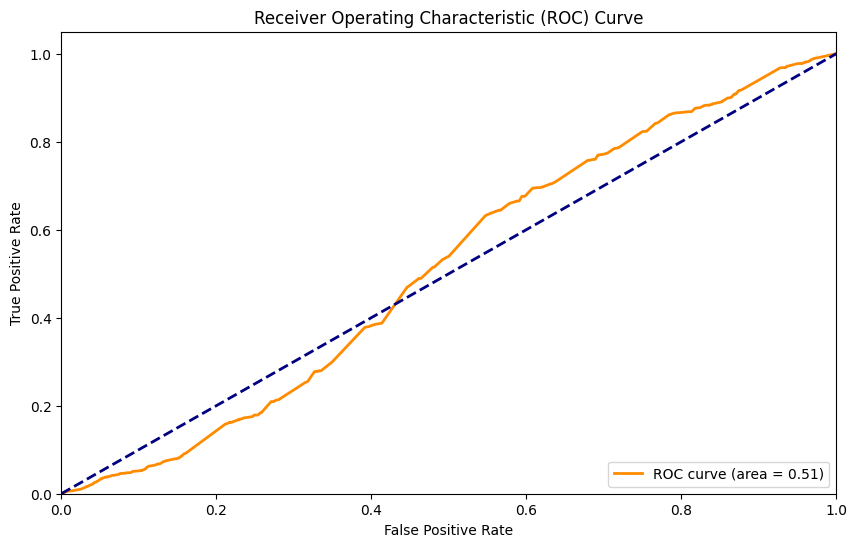

In [4]:
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
#accuracy = accuracy_score(Y_test, Y_pred)
#print(f'Accuracy: {accuracy * 100:.2f}%')
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
#plt.show()

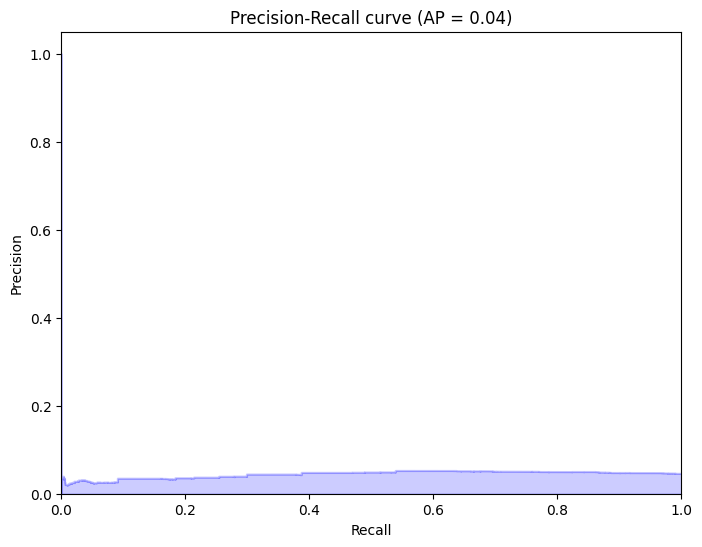

In [5]:
precision, recall, thresholds = precision_recall_curve(Y_test, Y_pred)

# Calculate the average precision score
average_precision = average_precision_score(Y_test, Y_pred)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

### GAN sampling

In [30]:
new_train_data = GANsampling(train_tgt,no_of_samples= 50000)
X_train = new_train_data.drop('label', axis=1)
Y_train = new_train_data['label']
X_test = test_tgt.drop(columns = ["label","gene_id","Transcript_ID","Base_seq"],axis = 1)
Y_test = test_tgt['label']

model = xgb.XGBClassifier(
    objective='binary:logistic', 
    n_estimators=100,            
    max_depth=3,                
    learning_rate=0.1,          
    subsample=0.8,             
    colsample_bytree=0.8,       
)

model.fit(X_train, Y_train)

Y_pred = model.predict_proba(X_test)[:, 1]

C:\ProgramData\Anaconda3\lib\site-packages\rdt\transformers\base.py:135: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  'strategy.', FutureWarning
C:\ProgramData\Anaconda3\lib\site-packages\rdt\transformers\base.py:135: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  'strategy.', FutureWarning
C:\ProgramData\Anaconda3\lib\site-packages\rdt\transformers\base.py:135: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  'strategy.', FutureWarning
C:\ProgramData\Anaconda3\lib\site-packages\rdt\transformers\base.py:135: FutureWarning: Future versions of RDT will not support the 'model_missing_v

KeyboardInterrupt: 

### Adasyn

In [6]:
new_train_data = adasyn_sample(train_tgt)
X_train = new_train_data.drop('label', axis=1)
Y_train = new_train_data['label']
X_test = test_tgt.drop(columns = ["label","gene_id","Transcript_ID","Base_seq"],axis = 1)
Y_test = test_tgt['label']

model = xgb.XGBClassifier(
    objective='binary:logistic', 
    n_estimators=100,            
    max_depth=3,                
    learning_rate=0.1,          
    subsample=0.8,             
    colsample_bytree=0.8,       
)

model.fit(X_train, Y_train)

Y_pred = model.predict_proba(X_test)[:, 1]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:33:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


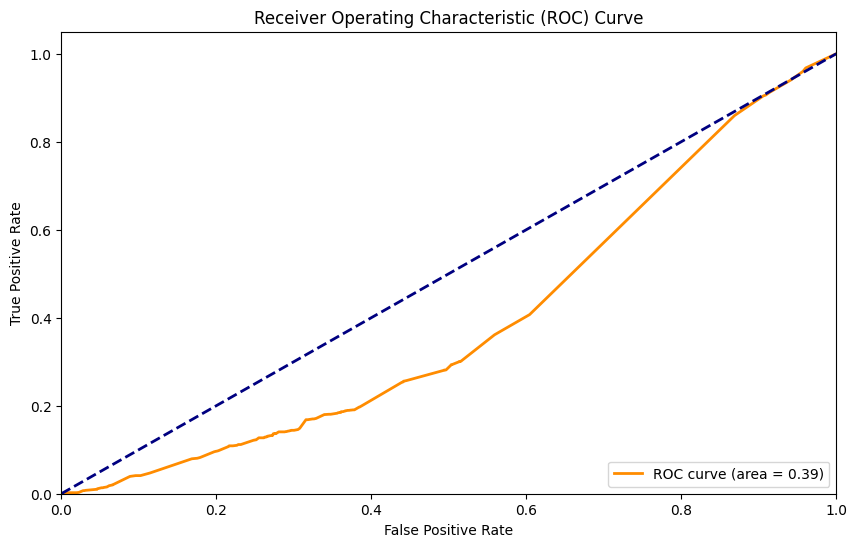

In [7]:
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
#accuracy = accuracy_score(Y_test, Y_pred)
#print(f'Accuracy: {accuracy * 100:.2f}%')
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
#plt.show()

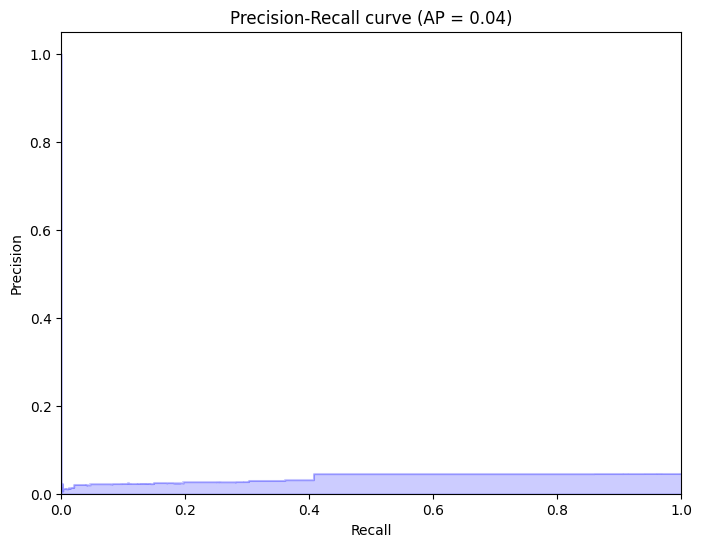

In [8]:
precision, recall, thresholds = precision_recall_curve(Y_test, Y_pred)

# Calculate the average precision score
average_precision = average_precision_score(Y_test, Y_pred)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

# Principal Components with mean and std separate

### Random Undersample

In [10]:
new_train_data = random_undersample(train_sep)
X_train = new_train_data.drop('label', axis=1)
Y_train = new_train_data['label']
X_test = test_sep.drop(columns = ["label","gene_id","Transcript_ID","Base_seq"],axis = 1)
Y_test = test_sep['label']

model = xgb.XGBClassifier(
    objective='binary:logistic', 
    n_estimators=100,            
    max_depth=3,                
    learning_rate=0.1,          
    subsample=0.8,             
    colsample_bytree=0.8,       
)

model.fit(X_train, Y_train)

Y_pred = model.predict_proba(X_test)[:, 1]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:36:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


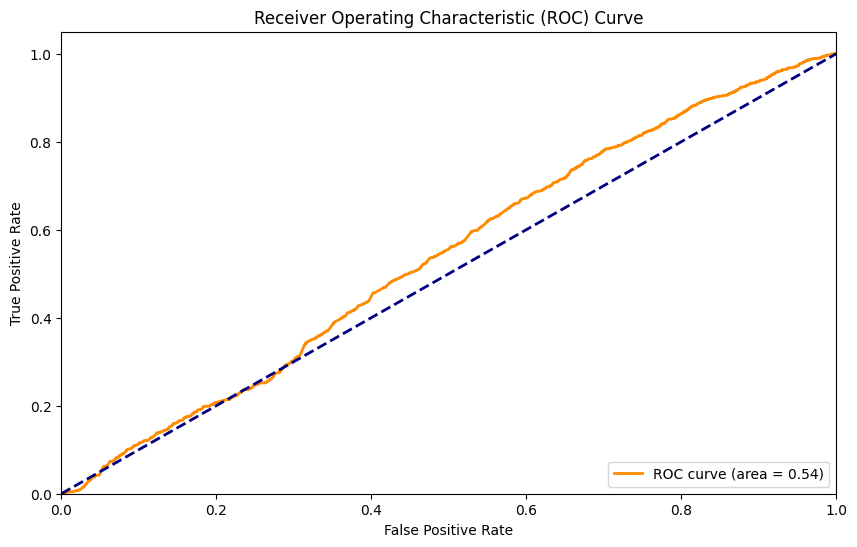

In [11]:
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
#accuracy = accuracy_score(Y_test, Y_pred)
#print(f'Accuracy: {accuracy * 100:.2f}%')
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

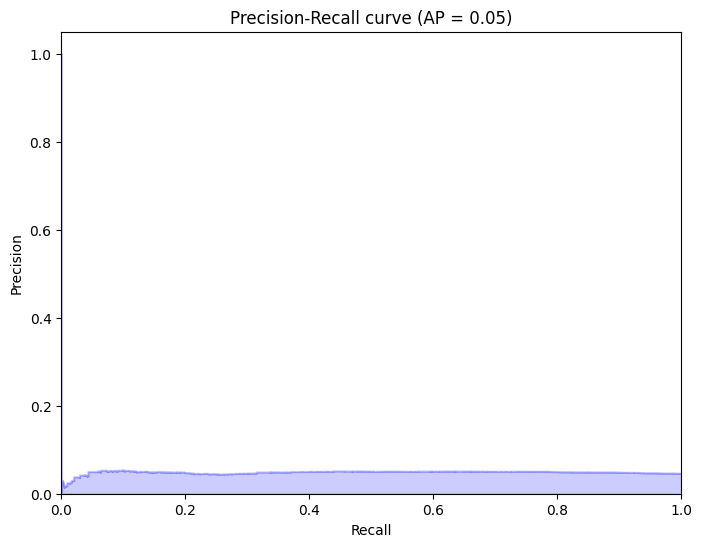

In [12]:
precision, recall, thresholds = precision_recall_curve(Y_test, Y_pred)

# Calculate the average precision score
average_precision = average_precision_score(Y_test, Y_pred)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

### GAN sampling

In [ ]:
new_train_data = GANsampling(train_sep,no_of_samples = 50000)
X_train = new_train_data.drop('label', axis=1)
Y_train = new_train_data['label']
X_test = test_tgt.drop(columns = ["label","gene_id","Transcript_ID","Base_seq"],axis = 1)
Y_test = test_tgt['label']

model = xgb.XGBClassifier(
    objective='binary:logistic', 
    n_estimators=100,            
    max_depth=3,                
    learning_rate=0.1,          
    subsample=0.8,             
    colsample_bytree=0.8,       
)

model.fit(X_train, Y_train)

Y_pred = model.predict_proba(X_test)[:, 1]

### Adasyn

In [13]:
new_train_data = adasyn_sample(train_sep)
X_train = new_train_data.drop('label', axis=1)
Y_train = new_train_data['label']
X_test = test_sep.drop(columns = ["label","gene_id","Transcript_ID","Base_seq"],axis = 1)
Y_test = test_sep['label']

model = xgb.XGBClassifier(
    objective='binary:logistic', 
    n_estimators=100,            
    max_depth=3,                
    learning_rate=0.1,          
    subsample=0.8,             
    colsample_bytree=0.8,       
)

model.fit(X_train, Y_train)

Y_pred = model.predict_proba(X_test)[:, 1]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:39:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


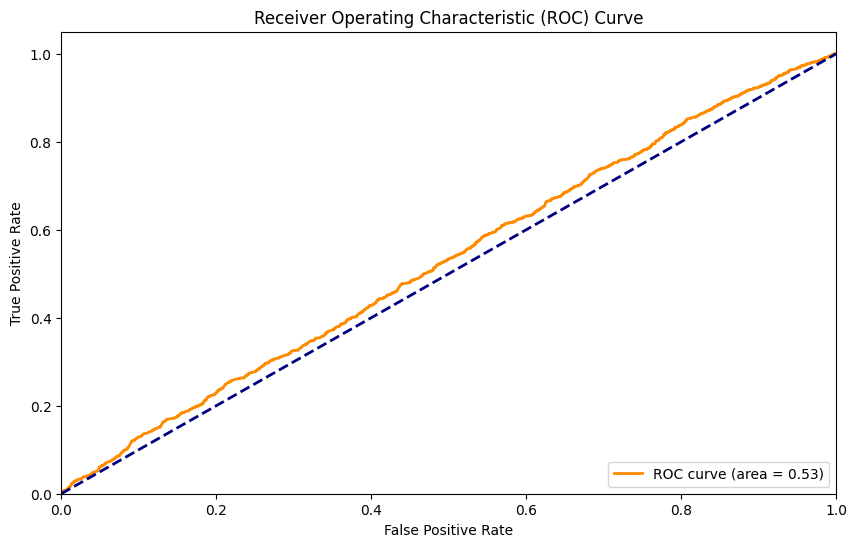

In [14]:
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
#accuracy = accuracy_score(Y_test, Y_pred)
#print(f'Accuracy: {accuracy * 100:.2f}%')
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

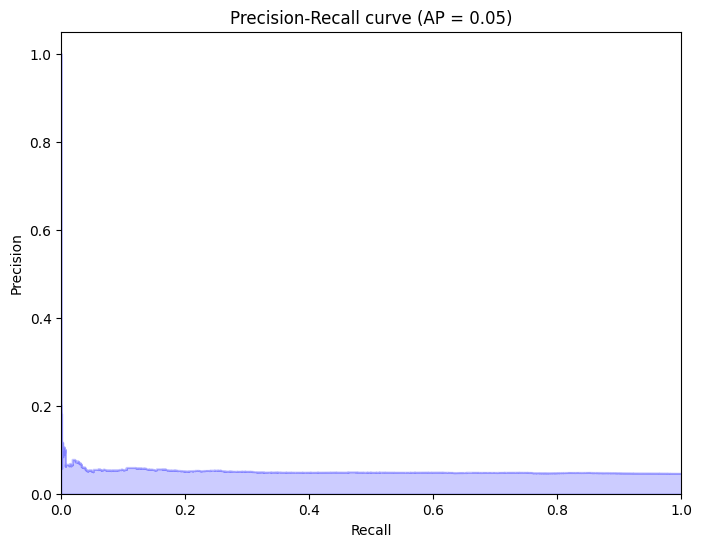

In [15]:
precision, recall, thresholds = precision_recall_curve(Y_test, Y_pred)

# Calculate the average precision score
average_precision = average_precision_score(Y_test, Y_pred)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

# No PCA

## Random Undersample

In [5]:
new_train_data = random_undersample(train_OG)
new_train_data.head()
#X_train = new_train_data.drop(['label',"Position"], axis=1)
#Y_train = new_train_data['label']
#X_test = test_OG.drop(columns = ["label","gene_id","Transcript_ID","Base_seq","Position"],axis = 1)
#Y_test = test_OG['label']

#model = xgb.XGBClassifier(
#    objective='binary:logistic', 
#    n_estimators=100,            
#    max_depth=3,                
#    learning_rate=0.1,          
#    subsample=0.8,             
#    colsample_bytree=0.8,       
#)

#model.fit(X_train, Y_train)

#Y_pred = model.predict_proba(X_test)[:, 1]

,Position,Base_seq,mean1,mean2,mean3,mean4,mean5,mean6,mean7,mean8,...,sd1,sd2,sd3,sd4,sd5,sd6,sd7,sd8,sd9,label
22594,2466,AAAACCC,0.009271,2.558205,106.538462,0.006783,4.030256,99.584615,0.006354,2.474103,...,0.006019,0.589754,1.630576,0.003375,0.608552,3.049635,0.003420,0.859540,1.726671,0
7943,1126,TAAACTG,0.006660,2.214172,105.760215,0.005852,2.803333,106.707527,0.006310,2.656204,...,0.004390,0.844597,4.282451,0.002604,0.936847,3.479625,0.003646,1.322954,2.681901,0
13954,5182,GAAACAT,0.013174,3.020000,105.840000,0.007510,3.229600,101.916000,0.007254,2.360800,...,0.007412,0.533059,1.222457,0.007219,0.806531,3.671804,0.004396,0.401636,1.907476,0
24954,1873,TGGACAA,0.009263,3.897200,118.200000,0.007349,6.511840,119.912000,0.007880,3.594480,...,0.006549,1.667096,2.742262,0.004267,2.710778,4.237010,0.005271,1.444386,4.177281,0
23163,2389,AGAACAG,0.009543,7.649130,127.782609,0.008159,4.053478,95.786957,0.008574,3.409522,...,0.005817,3.313146,3.438358,0.004765,1.813746,3.215628,0.005411,5.910375,2.890752,0


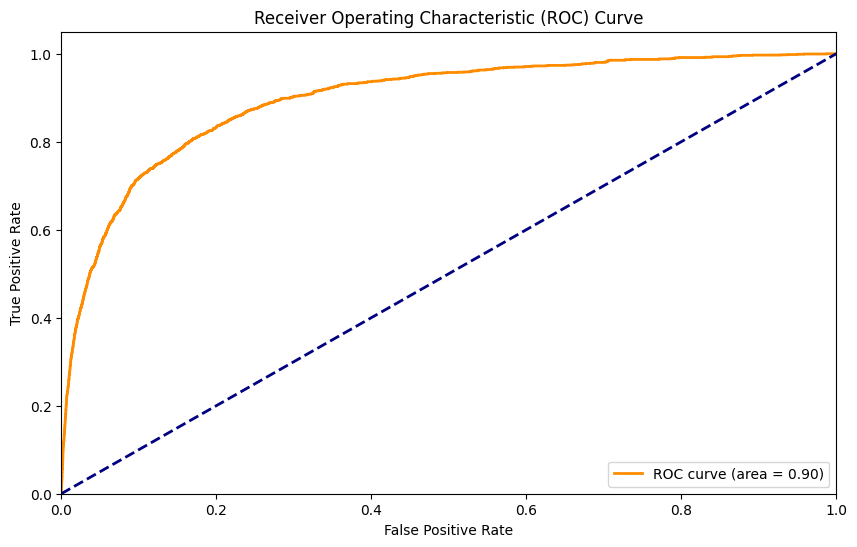

In [22]:
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
#accuracy = accuracy_score(Y_test, Y_pred)
#print(f'Accuracy: {accuracy * 100:.2f}%')
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [45]:
dataset0 = pd.concat([train_OG, test_OG], axis=0)
dataset0.reset_index(drop=True, inplace=True)
X_test_0 = dataset0.drop(columns = ["Transcript_ID","Base_seq","Position","label","gene_id"],axis = 1)
pred0 = model.predict_proba(X_test_0)[:, 1]
pred0_p = pd.DataFrame(pred0)
ds0_output = pd.concat([dataset0[["Transcript_ID","Position"]],pred0_p], axis = 1)
ds0_output.columns = ["transcript_id","transcript_position","score"]
ds0_output.to_csv("uip_dataset0_2.csv")


In [41]:
dataset0.head()

,gene_id,Transcript_ID,Position,label,Base_seq,mean1,mean2,mean3,mean4,mean5,...,mean9,sd1,sd2,sd3,sd4,sd5,sd6,sd7,sd8,sd9
0,ENSG00000004059,ENST00000000233,244,0,AAGACCA,0.008264,4.223784,123.702703,0.009373,7.382162,...,80.570270,0.005384,1.843025,4.944365,0.005364,3.302671,2.765244,0.004566,2.906225,2.522168
1,ENSG00000004059,ENST00000000233,261,0,CAAACTG,0.006609,3.216424,109.681395,0.006813,3.226535,...,94.290698,0.003588,1.689167,2.981182,0.003767,1.237045,3.526528,0.004528,1.466295,2.492530
2,ENSG00000004059,ENST00000000233,316,0,GAAACAG,0.007570,2.940541,105.475676,0.007416,3.642703,...,89.364324,0.004444,1.311103,1.492577,0.005035,0.893481,3.203816,0.004497,0.800496,1.484341
3,ENSG00000004059,ENST00000000233,332,0,AGAACAT,0.010620,6.476350,129.355000,0.008632,2.899200,...,89.154000,0.006121,2.459317,3.202963,0.004612,1.393868,1.928009,0.003595,0.741771,3.494937
4,ENSG00000004059,ENST00000000233,368,0,AGGACAA,0.010701,6.415051,117.924242,0.011479,5.870303,...,85.178788,0.007151,2.743228,2.664643,0.005407,1.753894,2.177236,0.005908,1.341822,2.379045


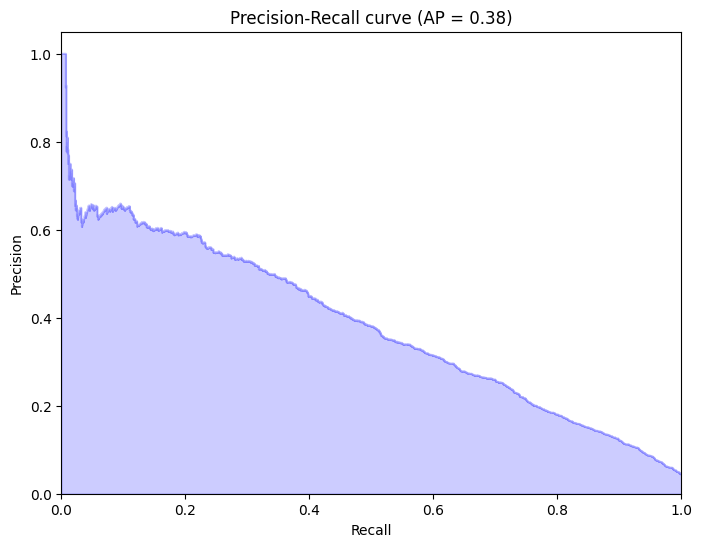

In [23]:
precision, recall, thresholds = precision_recall_curve(Y_test, Y_pred)

# Calculate the average precision score
average_precision = average_precision_score(Y_test, Y_pred)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

In [30]:
data1 = pd.read_csv("Data/ds1.csv")
data2 = pd.read_csv("Data/ds2.csv")

X_test_1 = data1.drop(columns = ["Transcript_ID","Base_seq","Position"],axis = 1)
X_test_2 = data2.drop(columns = ["Transcript_ID","Base_seq","Position"],axis = 1)

pred1 = model.predict_proba(X_test_1)[:, 1]
pred2 = model.predict_proba(X_test_2)[:, 1]

pred1_p = pd.DataFrame(pred1)
pred2_p = pd.DataFrame(pred2)

ds1_output = pd.concat([data1[["Transcript_ID","Position"]],pred1_p], axis = 1)
ds2_output = pd.concat([data2[["Transcript_ID","Position"]],pred2_p], axis = 1)

ds1_output.columns = ["transcript_id","transcript_position","score"]
ds2_output.columns = ["transcript_id","transcript_position","score"]

ds1_output.to_csv("uip_dataset1_2.csv")
ds2_output.to_csv("uip_dataset2_2.csv")

In [29]:
ds1_output

,transcript_id,transcript_position,score
0,ENST00000000233,244,0.121599
1,ENST00000000233,261,0.555944
2,ENST00000000233,316,0.042227
3,ENST00000000233,332,0.237542
4,ENST00000000233,368,0.364756
...,...,...,...
90805,ENST00000641784,3122,0.408300
90806,ENST00000641784,3142,0.094935
90807,ENST00000641784,3224,0.944019
90808,ENST00000641784,3243,0.386588


## Adasyn

In [9]:
new_train_data = adasyn_sample(train_OG)
X_train = new_train_data.drop('label', axis=1)
Y_train = new_train_data['label']
X_test = test_OG.drop(columns = ["label","gene_id","Transcript_ID","Base_seq"],axis = 1)
Y_test = test_OG['label']

model = xgb.XGBClassifier(
    objective='binary:logistic', 
    n_estimators=100,            
    max_depth=3,                
    learning_rate=0.1,          
    subsample=0.8,             
    colsample_bytree=0.8,       
)

model.fit(X_train, Y_train)

Y_pred = model.predict_proba(X_test)[:, 1]

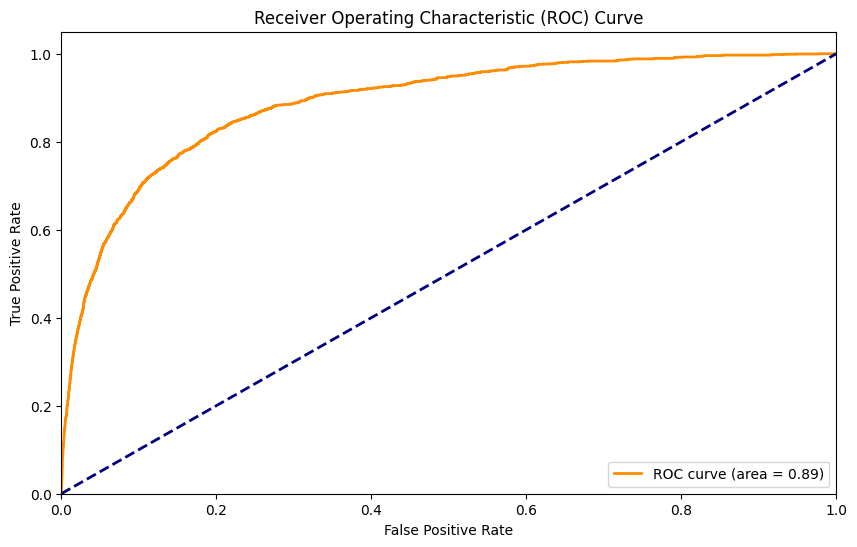

In [10]:
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
#accuracy = accuracy_score(Y_test, Y_pred)
#print(f'Accuracy: {accuracy * 100:.2f}%')
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

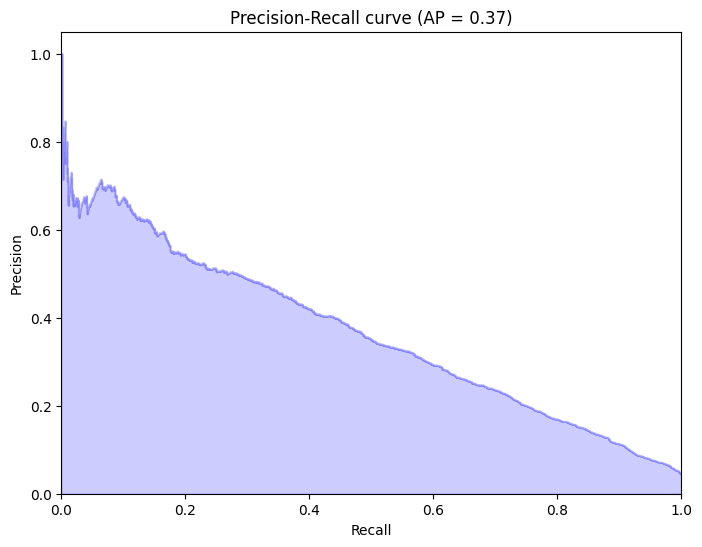

In [8]:
precision, recall, thresholds = precision_recall_curve(Y_test, Y_pred)

# Calculate the average precision score
average_precision = average_precision_score(Y_test, Y_pred)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

# Ways to convert base sequence to feature

## Target Encoding

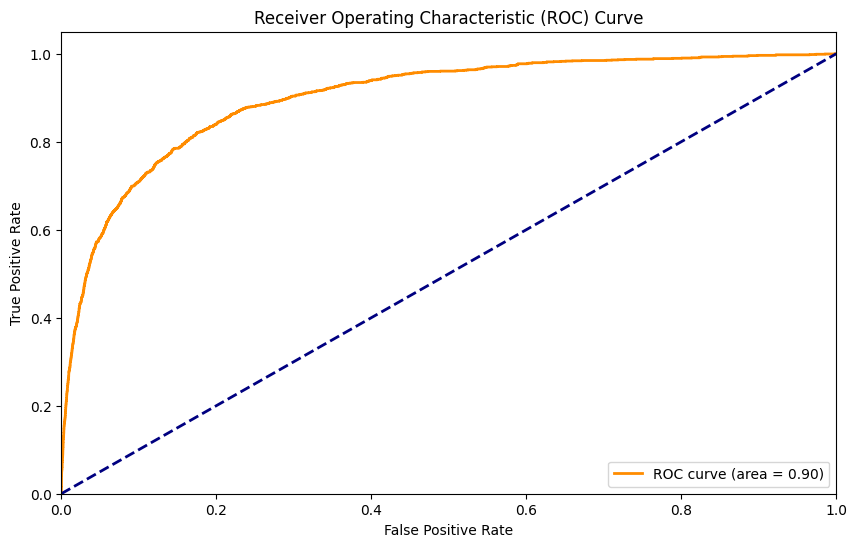

In [40]:
from sklearn.preprocessing import TargetEncoder

# Create a TargetEncoder instance
encoder = TargetEncoder()

target_encode_train_OG = train_OG.copy()
target_encode_test_OG = test_OG.copy()

# Fit and transform on the training data
target_encode_train_OG['Base_seq_encoded_category'] = encoder.fit_transform(np.array(target_encode_train_OG['Base_seq']).reshape(-1,1), np.array(target_encode_train_OG["label"]))

# Transform the validation or test data using the same encoder
target_encode_test_OG['Base_seq_encoded_category'] = encoder.transform(np.array(target_encode_test_OG['Base_seq']).reshape(-1,1))

new_train_data = random_undersample(target_encode_train_OG)
#new_train_data.head()
X_train = new_train_data.drop(['label',"Position","Base_seq"], axis=1)
Y_train = new_train_data['label']
X_test = target_encode_test_OG.drop(columns = ["label","gene_id","Transcript_ID","Base_seq","Position"],axis = 1)
Y_test = target_encode_test_OG['label']

model = xgb.XGBClassifier(
    objective='binary:logistic', 
    n_estimators=100,            
    max_depth=3,                
    learning_rate=0.1,          
    subsample=0.8,             
    colsample_bytree=0.8,       
)

model.fit(X_train, Y_train)

Y_pred = model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
#accuracy = accuracy_score(Y_test, Y_pred)
#print(f'Accuracy: {accuracy * 100:.2f}%')
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

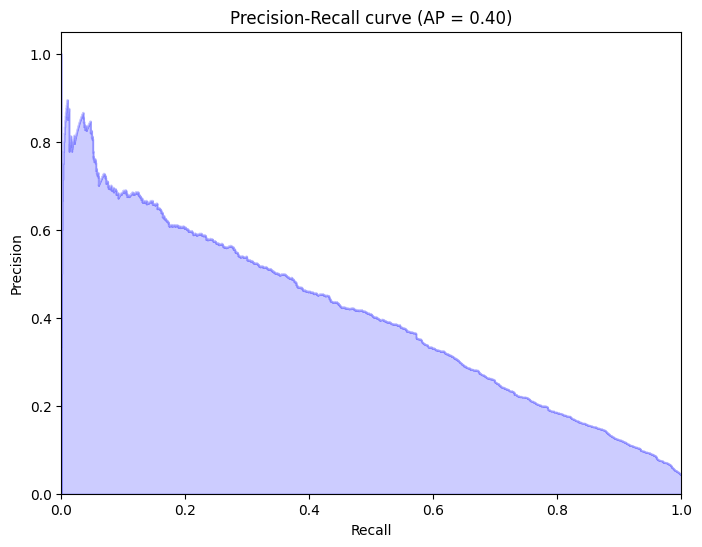

In [41]:
precision, recall, thresholds = precision_recall_curve(Y_test, Y_pred)

# Calculate the average precision score
average_precision = average_precision_score(Y_test, Y_pred)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

## One Hot Encoding
- The rationale is that there are only 4 distinct bases and the base sequence is of length 7 so there will be 28 binary columns

In [69]:
def base_seq_one_hot(rows):
    base_seq = rows["Base_seq"]
    output = [0] * 28
    for i in range(0,7):
        base = base_seq[i]
        if base == "A":
            output[(i+1)*4 - 4] = 1
        elif base == "C":
            output[(i+1)*4 - 3] = 1
        elif base == "G":
            output[(i+1)*4 - 2] = 1
        else:
            output[(i+1)*4 - 1] = 1
    return output


In [70]:
one_hot_encode_train_OG = random_undersample(train_OG)
one_hot_encode_test_OG = test_OG.copy()

one_hot_encode_train_OG["One_hot_encode_base_seq"] = one_hot_encode_train_OG.apply(base_seq_one_hot,axis=1)
one_hot_encode_test_OG["One_hot_encode_base_seq"] = one_hot_encode_test_OG.apply(base_seq_one_hot,axis=1)

In [71]:
new_column_train = one_hot_encode_train_OG['One_hot_encode_base_seq'].apply(pd.Series)
new_column_test = one_hot_encode_test_OG['One_hot_encode_base_seq'].apply(pd.Series)

In [72]:
new_column_train.columns = ['1A', '1C', '1G', '1T','2A', '2C', '2G', '2T','3A', '3C', '3G', '3T'
                             ,'4A', '4C', '4G', '4T','5A', '5C', '5G', '5T','6A', '6C', '6G', '6T'
                             ,'7A', '7C', '7G', '7T']

new_column_test.columns = ['1A', '1C', '1G', '1T','2A', '2C', '2G', '2T','3A', '3C', '3G', '3T'
                             ,'4A', '4C', '4G', '4T','5A', '5C', '5G', '5T','6A', '6C', '6G', '6T'
                             ,'7A', '7C', '7G', '7T']

In [73]:
one_hot_encode_train_OG = pd.concat([one_hot_encode_train_OG,new_column_train],axis = 1)
one_hot_encode_test_OG = pd.concat([one_hot_encode_test_OG,new_column_test],axis = 1)

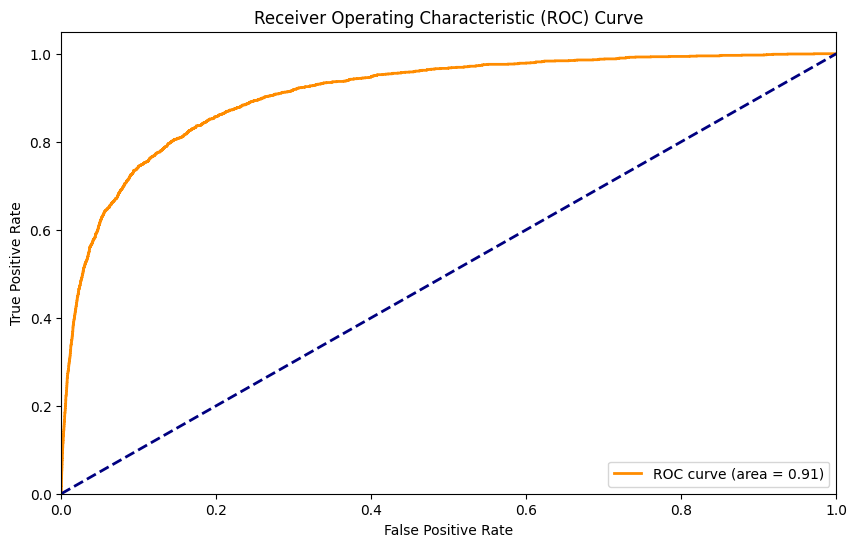

In [79]:
X_train = one_hot_encode_train_OG.drop(['label',"Position","Base_seq","One_hot_encode_base_seq"], axis=1)
Y_train = one_hot_encode_train_OG['label']
X_test = one_hot_encode_test_OG.drop(columns = ["One_hot_encode_base_seq","label","gene_id","Transcript_ID","Base_seq","Position"],axis = 1)
Y_test = one_hot_encode_test_OG['label']

model = xgb.XGBClassifier(
    objective='binary:logistic', 
    n_estimators=100,            
    max_depth=3,                
    learning_rate=0.1,          
    subsample=0.8,             
    colsample_bytree=0.8,       
)

model.fit(X_train, Y_train)

Y_pred = model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
#accuracy = accuracy_score(Y_test, Y_pred)
#print(f'Accuracy: {accuracy * 100:.2f}%')
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

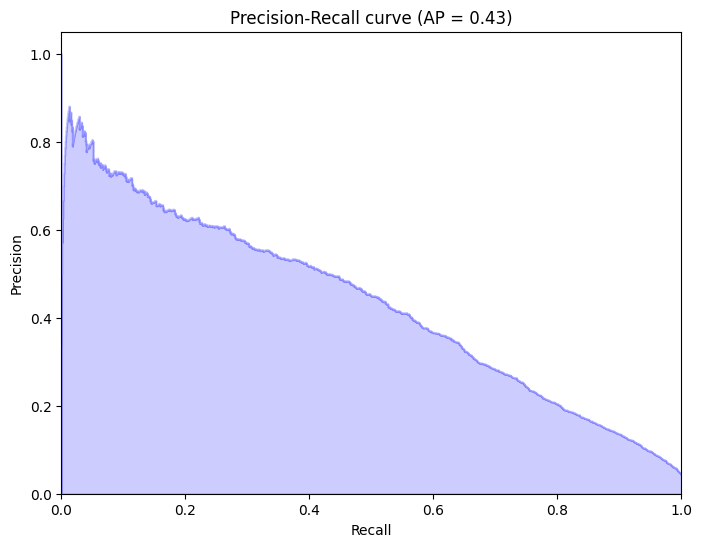

In [80]:
precision, recall, thresholds = precision_recall_curve(Y_test, Y_pred)

# Calculate the average precision score
average_precision = average_precision_score(Y_test, Y_pred)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()